In [ ]:
import os
import glob
import sklearn
import concurrent
import numpy as np
from PIL import Image
import zipfile
import shutil
import random


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# add your import here
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# set random seed to so that work can be replicated

random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Q2: News Classification by CNN 



### Q2.1 Data Processing

In [ ]:
import keras
from keras.datasets import reuters
import pandas as pd

In [ ]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# show the sizes training/testing samples 
len(train_data)
len(test_data)

# show an example from the training dataset
print(train_data[10])

# retrieve the mapping from words to indices
word_index = reuters.get_word_index()

# reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index[i - 3] for i in train_data[0] if (i-3) in reverse_word_index])

decoded_newswire

2121728/2110848 [==============================] - 0s 0us/step


8982

2246

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
565248/550378 [==============================] - 0s 0us/step


'said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [ ]:
# Pad or truncate sentences so that they have uniform length
# every sentence is 500 or less
DOC_LEN = 500

# convert numpy array to list
train_x = train_data.tolist()
test_x = test_data.tolist()

# truncate & padding function
def truncate_or_pad(doc):
    if len(doc) < DOC_LEN:
        doc += [0] * (DOC_LEN - len(doc))
    else:
        doc = doc[:DOC_LEN]
    return doc

train_x = list(map(truncate_or_pad, train_x))
test_x = list(map(truncate_or_pad, test_x))

In [ ]:
# add your code to create Dataset class
class news_dataset(Dataset):
    def __init__(self, featuers, labels):
        self.length = len(labels)
        self.features = torch.IntTensor(featuers)
        self.labels = torch.Tensor(labels).type(torch.LongTensor)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return self.length  


In [ ]:
train_dataset = news_dataset(train_x, train_labels)
test_dataset = news_dataset(test_x, test_labels)

### Define the model 

In [ ]:
class cnn_text(nn.Module):
    def __init__(self, num_words_in_dict, embedding_dim, dropout_ratio):
        super(cnn_text, self).__init__()
        self.num_words_in_dict = num_words_in_dict
        self.embedding_dim = embedding_dim
        self.dropout_ratio = dropout_ratio
   
        self.embedding = nn.Embedding(num_embeddings=num_words_in_dict, embedding_dim=embedding_dim)  
        self.unigram = nn.Sequential(
        nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=1),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN),  
        nn.Flatten()  
        )
      
        self.bigram = nn.Sequential(
        nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=2),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  
        nn.Flatten()  
        )
        # trigram
        self.trigram = nn.Sequential(
        nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  
        nn.Flatten()  
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=64*3, out_features=46)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        x = torch.transpose(x, dim0=1, dim1=2)  

        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)

        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        x = self.classifier(x)

        return x

In [ ]:
visual_model = cnn_text(num_words_in_dict=10000, embedding_dim=100, dropout_ratio=0.2)
print(visual_model)

cnn_text(
  (embedding): Embedding(10000, 100)
  (unigram): Sequential(
    (0): Conv1d(100, 64, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (bigram): Sequential(
    (0): Conv1d(100, 64, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=499, stride=499, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (trigram): Sequential(
    (0): Conv1d(100, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=498, stride=498, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=192, out_features=46, bias=True)
  )
)


### Train the model

In [ ]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0002, epochs=30, batch_size=64):
    
    # add your code here
        # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x)
            cur_train_loss = criterion(outputs, y)
            _, pred = torch.max(outputs, dim=-1) 
            
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                _, pred = torch.max(outputs, dim=-1)
                
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}      valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")
    
    return history

In [ ]:
# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# add code to train the model
model = cnn_text(num_words_in_dict=10000, embedding_dim=200, dropout_ratio=0.3)
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0002,
                      epochs=30,
                      batch_size=128)

Training Start
Epoch:1 / 30, train loss:2.07446 train_acc:0.49186      valid loss:1.73193 valid acc:0.57335
Epoch:2 / 30, train loss:1.70207 train_acc:0.58462      valid loss:1.56422 valid acc:0.64540
Epoch:3 / 30, train loss:1.56514 train_acc:0.63061      valid loss:1.46891 valid acc:0.66189
Epoch:4 / 30, train loss:1.45637 train_acc:0.65394      valid loss:1.39050 valid acc:0.66580
Epoch:5 / 30, train loss:1.38167 train_acc:0.67276      valid loss:1.33850 valid acc:0.67144
Epoch:6 / 30, train loss:1.31295 train_acc:0.68178      valid loss:1.29102 valid acc:0.68359
Epoch:7 / 30, train loss:1.25547 train_acc:0.69905      valid loss:1.23931 valid acc:0.69358
Epoch:8 / 30, train loss:1.20185 train_acc:0.70643      valid loss:1.19071 valid acc:0.70182
Epoch:9 / 30, train loss:1.16883 train_acc:0.72040      valid loss:1.16557 valid acc:0.71050
Epoch:10 / 30, train loss:1.10127 train_acc:0.73096      valid loss:1.12246 valid acc:0.72309
Epoch:11 / 30, train loss:1.07480 train_acc:0.73999   

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

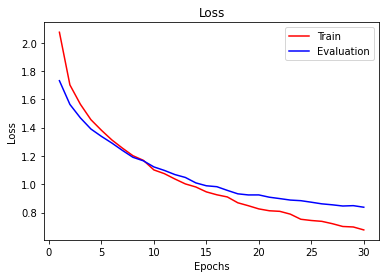

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

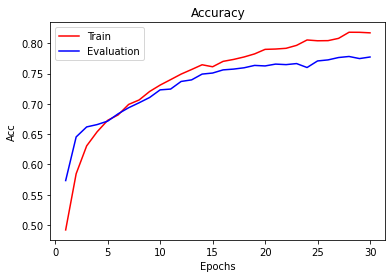

In [ ]:
# show training curve

epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Pretrained Wore Vectors 

In [ ]:
! pip install --upgrade gensim  &> /dev/null # install gensim 4.0.0 on colab

# Preprocessing 

In [ ]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
# word_index is a dictionary mapping words to an integer index
word_index = reuters.get_word_index()

len(word_index)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

30979

In [ ]:
# get doc list
doc_list = []
for cur_sentence in np.concatenate((train_data, test_data)):
    sentence_list = []
    for cur_word_index in cur_sentence:
        cur_word = reverse_word_index.get(cur_word_index - 3)
        if cur_word:
            sentence_list.append(cur_word)
    doc_list.append(sentence_list)
# concat labels
doc_labels = np.concatenate((train_labels, test_labels))

### Train word2vec model with Gensim

In [ ]:
from gensim.models import word2vec
def train_word2vec(corpus, size, window, min_count, epochs, sg, workers, save):
  model = word2vec.Word2Vec(corpus, 
                            vector_size=size,  
                            window=window,   
                            min_count=min_count,  
                            epochs=epochs,  
                            sg=sg, 
                            workers=workers,  
                            )
  print('Done')
  if save:
    print('Saving:')
    model.save(os.path.join(cwd_path, 'word2vec.model'))
    print('Done')
  
  return model

In [ ]:
word2vec_model = train_word2vec(corpus=doc_list,
                                size=100,
                                window=5,
                                min_count=4,
                                epochs=3,
                                sg=1,  
                                workers=3,
                                save=False)

Done


### Construct embedding dicionary and embedding matrix

In [ ]:
# embedding dictionaries and embedding matrix
def construct_embeddingDict(word2vec_model, max_num_words):
  index2word = []
  word2index = {}
  embedding_matrix = []

  counter = 0
  for cur_word in word2vec_model.wv.key_to_index:
    if cur_word in word2vec_model.wv:
      word2index[cur_word] = len(word2index)
      index2word.append(cur_word)
      embedding_matrix.append(word2vec_model.wv[cur_word])
    counter += 1
    if counter >= max_num_words:
      break
  
  # add <PAD> and <UNK>
  word2index['<PAD>'] = len(word2index)
  index2word.append('<PAD>')

  embedding_matrix.append(np.zeros(len(embedding_matrix[0])))
  word2index['<UNK>'] = len(word2index)
  index2word.append('<UNK>')

  embedding_matrix.append(np.zeros(len(embedding_matrix[0])))

  return index2word, word2index, np.array(embedding_matrix)

In [ ]:
index2word, word2index, embedding_matrix = construct_embeddingDict(word2vec_model, 10000)

### Sentence length and sentence to index

In [ ]:
def sentence_length(text_list, lim):
  print('Sentence length process:')
  for i in range(len(text_list)):
    if len(text_list[i]) > lim:  # if length is too long, truncate
      text_list[i] = text_list[i][:lim]
    else:  # if length is too short, padding
      pad_len = lim - len(text_list[i])
      for _ in range(pad_len):
        text_list[i].append('<PAD>')
  print('Done')
  
  return text_list

def sentence2index(text_list, word2index):
  print('Sentence to index')
  result_list = []
  for cur_sentence in text_list:
    cur_result = []
    for cur_word in cur_sentence:
      if cur_word in word2index.keys():
        cur_result.append(word2index[cur_word])
      else:
        cur_result.append(word2index['<UNK>'])
    result_list.append(cur_result)
  print('Done')

  return result_list

In [ ]:
text_list = sentence_length(doc_list, DOC_LEN)
text_index_list = sentence2index(text_list, word2index)

Sentence length process:
Done
Sentence to index
Done


### 70-30 Dataset Train-Test Split

In [ ]:
#X_train, y_train , X_test, y_test  = train_test_split(text_index_list, doc_labels, shuffle=True, test_size=0.3, random_state=123)
text_dataset = news_dataset(featuers=text_index_list, labels=doc_labels)
# Create indices for the split
len_dataset = len(text_dataset)
train_size = int(0.7 * len_dataset)
test_size = len_dataset - train_size

train_data, test_data = random_split(text_dataset,[train_size, test_size])
print(len(train_data))
print(len(test_data))

7859
3369


### Use pretrained embedding matrix in CNN model

In [ ]:
class TextCNN_pretrained(nn.Module):
    def __init__(self, pre_trained_embedding, dropout_ratio):
        super(TextCNN_pretrained, self).__init__()
        self.pre_trained_embedding = torch.Tensor(pre_trained_embedding)       
        self.num_embeddings = pre_trained_embedding.shape[0]
        self.embedding_dim = pre_trained_embedding.shape[1]
        
        self.dropout_ratio = dropout_ratio
        # embedding
        self.embedding = nn.Embedding(num_embeddings=self.num_embeddings, embedding_dim=self.embedding_dim)
        self.embedding.weight = nn.Parameter(self.pre_trained_embedding)
        self.embedding.weight.requires_grad = True
        # fine-tuning: self.embedding.weight.requires_grad = True
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=64, kernel_size=1),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN),  
        nn.Flatten()  
        )
        # bigram
        self.bigram = nn.Sequential(
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=64, kernel_size=2),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  
        nn.Flatten()  
        )
        # trigram
        self.trigram = nn.Sequential(
        nn.Conv1d(in_channels=self.embedding_dim, out_channels=64, kernel_size=3),  
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  
        nn.Flatten()  
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=64*3, out_features=46)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        
        x = torch.transpose(x, dim0=1, dim1=2)  
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)
        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        x = self.classifier(x)

        return x

### Train model 

In [ ]:
model = TextCNN_pretrained(pre_trained_embedding=embedding_matrix, dropout_ratio=0.3)

history = train_model(model=model,
                      train_dataset=train_data,
                      test_dataset=test_data,
                      device=device,
                      lr=0.0005,
                      epochs=30,
                      batch_size=128)

Training Start
Epoch:1 / 30, train loss:1.84331 train_acc:0.55557      valid loss:1.50034 valid acc:0.65972
Epoch:2 / 30, train loss:1.41455 train_acc:0.66318      valid loss:1.31818 valid acc:0.67535
Epoch:3 / 30, train loss:1.28380 train_acc:0.68649      valid loss:1.21846 valid acc:0.69271
Epoch:4 / 30, train loss:1.18003 train_acc:0.70766      valid loss:1.14404 valid acc:0.71296
Epoch:5 / 30, train loss:1.08980 train_acc:0.73034      valid loss:1.09558 valid acc:0.72772
Epoch:6 / 30, train loss:1.02328 train_acc:0.74836      valid loss:1.04285 valid acc:0.74277
Epoch:7 / 30, train loss:0.96673 train_acc:0.75995      valid loss:0.99801 valid acc:0.75029
Epoch:8 / 30, train loss:0.91348 train_acc:0.77356      valid loss:0.96156 valid acc:0.75839
Epoch:9 / 30, train loss:0.86633 train_acc:0.78314      valid loss:0.91752 valid acc:0.76157
Epoch:10 / 30, train loss:0.82595 train_acc:0.79398      valid loss:0.92016 valid acc:0.77373
Epoch:11 / 30, train loss:0.79362 train_acc:0.79751   

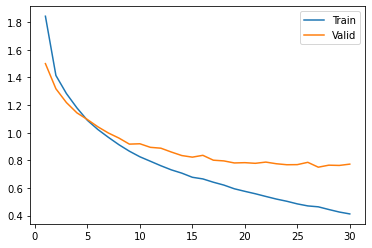

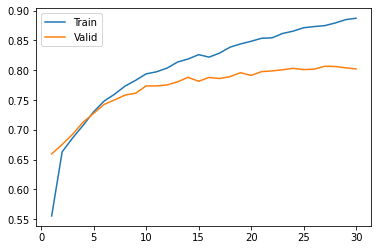

In [ ]:
plt.plot(range(1, 31), history['train_loss'], label='Train')
plt.plot(range(1, 31), history['test_loss'], label='Valid')
plt.legend()
plt.show()
plt.plot(range(1, 31), history['train_acc'], label='Train')
plt.plot(range(1, 31), history['test_acc'], label='Valid')
plt.legend()
plt.show()